# Gather Dataset
The dataset will be gathered using Google's iCrawler, all code below by William

In [2]:
from icrawler.builtin import GoogleImageCrawler
import datetime
def datetime2tuple(date):
    return (date.year, date.month, date.day)
def gather_data(n_total_images,n_per_crawl,keyword, folder_name): #collects data by sending google different search queries with different date constraints to mitigate duplicate images
    delta = datetime.timedelta(days=30)
    end_day = datetime.datetime(2023, 3, 17)
    for i in range(int(n_total_images / n_per_crawl )):
        start_day = end_day - delta
        google_crawler = GoogleImageCrawler(downloader_threads=4, storage={'root_dir': folder_name})
        google_crawler.crawl(keyword=keyword[i], filters={'date':(datetime2tuple(start_day), datetime2tuple(end_day))}, file_idx_offset=i*n_per_crawl , max_num=n_per_crawl)
        end_day = start_day - datetime.timedelta(days=1)

#each call gathers data from the query and sends it to its respective directory to be manually cleaned

#gather_data(900,100,['cardboard boxes with tape on it','cardboard boxes with tape on it','packages ready to ship','packages about to be sent','cardboard boxes',
#           'packages','box packages','sealed packages','delivery cardboard package box'],'data/startingdata/goodpackages')
#gather_data(200,100,['ripped cardboard boxes','ripped packages'],'data/startingdata/rippedpackages') #ripped
#gather_data(200,100,['destroyed packages','damaged cardboard boxes'],'data/startingdata/crushedpackages') #crushed
#gather_data(200,100,['cardboard boxes with water damage','wet cardboard boxes'],'data/startingdata/leakingpackages')#leaking
#gather_data(200,100,['burned cardboard','charred cardboard'],'data/startingdata/burnedpackages') # burned
#gather_data(200,100,['cardboard recycling pile','broken down cardboard boxes'],'data/startingdata/foldedpackages')#folded

2023-04-23 15:58:59,328 - INFO - icrawler.crawler - start crawling...
2023-04-23 15:58:59,328 - INFO - icrawler.crawler - starting 1 feeder threads...
2023-04-23 15:58:59,329 - INFO - feeder - thread feeder-001 exit
2023-04-23 15:58:59,330 - INFO - icrawler.crawler - starting 1 parser threads...
2023-04-23 15:58:59,332 - INFO - icrawler.crawler - starting 4 downloader threads...
2023-04-23 15:59:00,359 - INFO - parser - parsing result page https://www.google.com/search?q=crushed+boxes&ijn=0&start=0&tbs=cdr%3A1%2Ccd_min%3A02%2F15%2F2023%2Ccd_max%3A03%2F17%2F2023&tbm=isch
2023-04-23 15:59:00,535 - ERROR - downloader - Response status code 400, file https://media.istockphoto.com/id/1165557816/photo/cardboard-boxes.jpg
2023-04-23 15:59:00,586 - ERROR - downloader - Response status code 400, file https://media.istockphoto.com/id/1215484506/photo/crumpled-cardboard-mail-box.jpg
2023-04-23 15:59:00,593 - ERROR - downloader - Response status code 400, file https://media.istockphoto.com/id/6642

IndexError: list index out of range

# ResNet

## Split the Data
After manually cleaning the data, it is ready to be split into testing and training sets.
The different categories of data will be merged into "bad packages" to allow for binary image classification

In [10]:
import splitfolders
import shutil
import os
input_folder = "data\\startingdata\\"
output_folder = "data\\split data\\"
splitfolders.ratio(input_folder, output=output_folder, #splits the data 80% for training and 20% for testing
                   seed=2, ratio=(.6, .2, .2))
subsets = ['test\\', 'train\\','val\\'] 
for subset in subsets: #will be moving images for the training and testing sets
    output = output_folder+subset
    destination = "data\\split data\\"+subset+"\\badpackages\\"
    categories = ['burnedpackages', 'crushedpackages',
                  'foldedpackages', 'leakingpackages', 'rippedpackages']
    for category in categories: #will merge each directory of bad packages into a single one
        source_folder = output + category
        for file_name in os.listdir(source_folder):

            if os.path.exists(destination + '\\' + file_name): #if the already path exists, it renames the new image and moves it
                data = os.path.splitext(file_name)
                only_name = data[0]
                extension = data[1]
                new_base = category + only_name + extension
                new_name = os.path.join(destination, new_base)
                shutil.move(source_folder + '\\' + file_name, new_name)
            else:
                shutil.move(source_folder + '\\' + file_name, #if the path is not already used, the new file will take its place
                            destination + '\\' + file_name)
        os.rmdir(source_folder)



Copying files: 1000 files [00:01, 710.18 files/s]


## Processing the Data
The data will be preprocessed using Keras' ImageDataGenerator

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

img_height,img_width = (224,224) #the size required by resnet

train_data_path = "data/split data/train/"
test_data_path = "data/split data/test/"
val_data_path = "data/split data/val/"
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,validation_split=0.4) #randomly flips images and saves 40% for validation
training_data_generator = training_datagen.flow_from_directory(train_data_path,target_size=(img_height,img_width),class_mode='categorical',subset='training')
testing_data_generator = training_datagen.flow_from_directory(test_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')
validation_data_generator = training_datagen.flow_from_directory(val_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')


Found 464 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


## Train the Model

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #This is required to get around an error thrown by larger images

base_model = ResNet50(include_top=False,weights='imagenet')

output=base_model.output #add new layers to the model
output=GlobalAveragePooling2D()(output) #adds global average poolinglayer
output=Dense(1024,activation='relu')(output)  #adds dense layer
predictions = Dense(training_data_generator.num_classes,activation='softmax')(output)
model = Model(inputs=base_model.input,outputs=predictions) 

for layer in base_model.layers: #freezes all of the weights in the base_model layers
    layer.trainable = False

model.compile(optimizer='adam',loss='binary_crossentropy') 
model.fit(training_data_generator,epochs=10,validation_data = validation_data_generator) # trains the newly added layers [] learning rate

Epoch 1/10
12/15 [=======================>......] - ETA: 5s - loss: 0.9950

c:\Users\willi\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 47s 3s/step - loss: 0.9020 - val_loss: 0.4561
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.2446 - val_loss: 0.3041
Epoch 3/10
15/15 [==============================] - 40s 3s/step - loss: 0.1391 - val_loss: 0.3434
Epoch 4/10
15/15 [==============================] - 39s 3s/step - loss: 0.0846 - val_loss: 0.4065
Epoch 5/10
15/15 [==============================] - 40s 3s/step - loss: 0.0647 - val_loss: 0.4214
Epoch 6/10
15/15 [==============================] - 39s 3s/step - loss: 0.0532 - val_loss: 0.3254
Epoch 7/10
15/15 [==============================] - 40s 3s/step - loss: 0.0389 - val_loss: 0.4006
Epoch 8/10
15/15 [==============================] - 43s 3s/step - loss: 0.0220 - val_loss: 0.3531
Epoch 9/10
15/15 [==============================] - 41s 3s/step - loss: 0.0220 - val_loss: 0.4017
Epoch 10/10
15/15 [==============================] - 40s 3s/step - loss: 0.0193 - val_loss: 0.4441


## Evaluation

In [13]:
samples = len(testing_data_generator)
predicted = []
actual=[]
#print(testing_data_generator.class_indices)
for i in range(samples): #runs each sample in the test set
    x,y=testing_data_generator.next() #x is the image and y is the label
    predicted.append((model.predict(x)))
    actual.append(y)

1/1 [==============================] - 0s 114ms/step


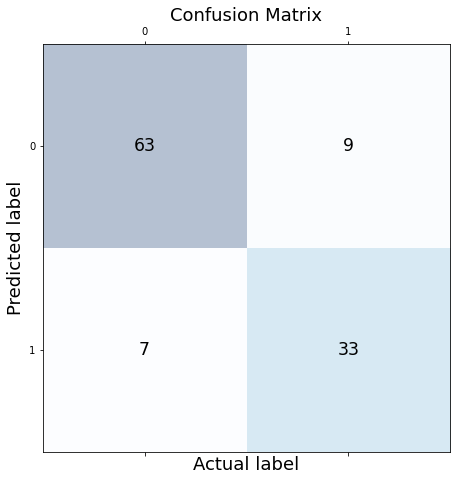

Accuracy: 0.8571428571428571
Precision: 0.875
Recall: 0.9
Specificity: 0.7857142857142857
F1-Score: 0.8873239436619719


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#model.save('Models\\Resnet50\\Resnet50_with_50_10_datasplit.h5')
predicted_class = [i.argmax() for i in predicted]
actual_class = [i.argmax() for i in actual]

conf_matrix = confusion_matrix(actual_class, predicted_class) #creates confusion matrix from predictions and actuals
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actual label', fontsize=18)
plt.ylabel('Predicted label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
recall = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])

print("Accuracy:",  (conf_matrix[0][0]+conf_matrix[1][1])/((conf_matrix[0][0]+conf_matrix[0][1])+(conf_matrix[1][0]+conf_matrix[1][1])))
print("Precision:",  precision)
print("Recall:",  recall)
print("Specificity:",  (conf_matrix[1][1])/(conf_matrix[1][1]+conf_matrix[0][1]))
print("F1-Score:",  (2*precision * recall)/(precision+recall))


# VGG

## Processing the Data

In [15]:
from tensorflow.keras.applications.vgg19 import preprocess_input,VGG19
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

img_height,img_width = (224,224) #the size required by resnet

train_data_path = "data/split data/train/"
test_data_path = "data/split data/test/"
val_data_path = "data/split data/val/"

VGG_training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,validation_split=0.4) #randomly flips images and saves 40% for validation
VGG_training_data_generator = VGG_training_datagen.flow_from_directory(train_data_path,target_size=(img_height,img_width),class_mode='categorical',subset='training')
VGG_testing_data_generator = VGG_training_datagen.flow_from_directory(test_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')
VGG_validation_data_generator = VGG_training_datagen.flow_from_directory(val_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')

Found 464 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


## Train the Model

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #This is required to get around an error thrown by larger images

base_model = VGG19(include_top=False,weights='imagenet')

output=base_model.output #add new layers to the model
output=GlobalAveragePooling2D()(output) #adds global average poolinglayer
output=Dense(1024,activation='relu')(output)  #adds dense layer
predictions = Dense(VGG_training_data_generator.num_classes,activation='softmax')(output)
model = Model(inputs=base_model.input,outputs=predictions) 

for layer in base_model.layers: #freezes all of the weights in the base_model layers
    layer.trainable = False

model.compile(optimizer='adam',loss='binary_crossentropy') 
model.fit(VGG_training_data_generator,epochs=10,validation_data = VGG_validation_data_generator) # trains the newly added layers
model.save('Models\\VGG.h5')

Epoch 1/10
 6/15 [===========>..................] - ETA: 36s - loss: 1.9442

c:\Users\willi\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 82s 5s/step - loss: 1.5381 - val_loss: 0.5038
Epoch 2/10
15/15 [==============================] - 77s 5s/step - loss: 0.5237 - val_loss: 0.5295
Epoch 3/10
15/15 [==============================] - 78s 5s/step - loss: 0.1528 - val_loss: 0.3713
Epoch 4/10
15/15 [==============================] - 77s 5s/step - loss: 0.0745 - val_loss: 0.2804
Epoch 5/10
15/15 [==============================] - 80s 5s/step - loss: 0.0641 - val_loss: 0.2946
Epoch 6/10
15/15 [==============================] - 80s 5s/step - loss: 0.0576 - val_loss: 0.2987
Epoch 7/10
15/15 [==============================] - 81s 5s/step - loss: 0.0216 - val_loss: 0.2914
Epoch 8/10
 9/15 [=================>............] - ETA: 59s - loss: 0.0179 

## Evaluation

In [ ]:
samples = len(VGG_testing_data_generator)
predicted = []
actual=[]
#print(testing_data_generator.class_indices)
for i in range(samples): #runs each sample in the test set
    x,y=VGG_testing_data_generator.next() #x is the image and y is the label
    predicted.append((model.predict(x)))
    actual.append(y)

1/1 [==============================] - 0s 128ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predicted_class = [i.argmax() for i in predicted]
actual_class = [i.argmax() for i in actual]

conf_matrix = confusion_matrix(actual_class, predicted_class) #creates confusion matrix from predictions and actuals
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actual label', fontsize=18)
plt.ylabel('Predicted label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
recall = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])

print("Accuracy:",  (conf_matrix[0][0]+conf_matrix[1][1])/((conf_matrix[0][0]+conf_matrix[0][1])+(conf_matrix[1][0]+conf_matrix[1][1])))
print("Precision:",  precision)
print("Recall:",  recall)
print("Specificity:",  (conf_matrix[1][1])/(conf_matrix[1][1]+conf_matrix[0][1]))
print("F1-Score:",  (2*precision * recall)/(precision+recall))

NameError: name 'predicted' is not defined

## Clean up

In [1]:
import os, shutil
start_folder = 'data/split data/'
category = ["test/","train/"]
category = ["test/","train/","val/"]
classification = ["goodpackages","badpackages"]
for type in category:
    class_folder = start_folder + type
    for class_type in classification:
        folder = class_folder + class_type
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))